LSTM

In [1]:
from datetime import datetime, timedelta
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [ ]:
acao = 'MGLU3.SA'
periodo_tempo_de_precos_acao = "5y"
ativo = yf.download(acao, period=periodo_tempo_de_precos_acao)

C:\Users\pedro\AppData\Local\Temp\ipykernel_6976\839939156.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ativo = yf.download(acao, period="5y")
[*********************100%***********************]  1 of 1 completed


In [4]:
ativo.head()

Price,Close,High,Low,Open,Volume
Ticker,MGLU3.SA,MGLU3.SA,MGLU3.SA,MGLU3.SA,MGLU3.SA
Date,,,,,
2020-07-31,182.890228,192.044933,181.281353,190.798622,4869332
2020-08-03,187.105026,187.626210,180.737517,184.023228,4058019
2020-08-04,186.946381,188.532602,183.139485,184.567071,3370256
2020-08-05,188.079391,191.319795,187.852795,188.759196,3239949
2020-08-06,194.673508,195.308005,189.212415,190.345428,4712723


In [ ]:
# Pega somente o atributo "Close" (preço de fechamento da ação em cada dia) e armazena em um array bidimensional
# O array precisa ser bidimensional porque o MinMaxScaler espera uma entrada com esse formato.
ativo_close = ativo['Close'].dropna().to_numpy().reshape(-1, 1)

In [8]:
# Criar um DataFrame com os valores ajustados
data = pd.DataFrame(ativo_close)
data.columns = ['Close']

In [9]:
# Normalizar os dados para os modelos
scaler = MinMaxScaler(feature_range=(0, 1))
data['Scaled_Close'] = scaler.fit_transform(data[['Close']])

In [27]:
# Função para criar janelas de dados
# janela de dados = quantidade de dias do X
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)


In [28]:
window_size = 60
scaled_data = data['Scaled_Close'].values
X, y = create_dataset(scaled_data, window_size)

In [ ]:
X[0] # 60 (window-size) valores que ele usa para prever o valor do y. 

array([0.00179653, 0.00335352, 0.0031539 , 0.00143722, 0.00079846,
       0.0008783 , 0.        , 0.00039923, 0.00223568, 0.000519  ,
       0.00099807, 0.00119769, 0.0013973 , 0.00223568, 0.0019163 ,
       0.00223568, 0.00479074, 0.00379267, 0.00311398, 0.00582873,
       0.00658727, 0.00562912, 0.00570896, 0.00427174, 0.00630781,
       0.00503028, 0.00578881, 0.00582873, 0.00511012, 0.00479074,
       0.00626788, 0.00858341, 0.00746557, 0.00654734, 0.00622796,
       0.00586866, 0.00423182, 0.00626788, 0.00618804, 0.00598842,
       0.00534966, 0.00586866, 0.00518997, 0.00818418, 0.00974117,
       0.00994079, 0.01105862, 0.01057955, 0.01513075, 0.01728659,
       0.01684743, 0.01844435, 0.01820481, 0.01712689, 0.01756604,
       0.01856412, 0.01868388, 0.02020095, 0.01896334, 0.0173265 ])

In [43]:
scaled_data.shape, X.shape, y.shape

((1244,), (1184, 60), (1184,))

In [ ]:
# Dividir os dados em treinamento e teste
# O argumento shuffle=False desativa a aleatorização dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [26]:
# Ajustar o formato para o LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [70]:
len(X_test)
# X = 1184 (5 anos de dias úteis em janelas de 60 dias [71040 valores])
# X_test = 237 dias (20% dos 5 anos de dias úteis em janelas de 60 dias [14220 valores])
# y = 1184 valores reais da ação
# y_test = 20% dos valores reais da ação que serão utilizados para comparmos as nossas previsões

237

In [71]:
# Criação de um modelo sequencial, onde as camadas são empilhadas uma após a outra
model = Sequential([
    # Define a forma da entrada: uma sequência de 'window_size' passos, cada um com 1 feature (ex: preço de fechamento da ação)
    Input(shape=(window_size, 1)),
    # Primeira camada LSTM com 100 unidades; retorna a sequência completa (uma saída por passo de tempo)
    LSTM(100, return_sequences=True),
    # Dropout de 30% para evitar overfitting (desativa aleatoriamente 30% dos neurônios durante o treino)
    Dropout(0.3),
    # Segunda camada LSTM com 100 unidades; também retorna a sequência completa
    LSTM(100, return_sequences=True),
    # Outro Dropout de 30% para regularização
    Dropout(0.3),
    # Terceira camada LSTM com 100 unidades; agora retorna apenas a última saída da sequência
    LSTM(100),
    # Mais um Dropout de 30% antes da saída final
    Dropout(0.3),
    # Camada densa (totalmente conectada) com 1 unidade; representa o valor final previsto (ex: o próximo valor)
    Dense(1)
])


In [51]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


In [52]:
# Treinar o modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

model.fit(X_train, y_train, 
               epochs=100, 
               batch_size=32, 
               validation_data=(X_test, y_test),
               callbacks=[early_stopping, reduce_lr], 
               verbose=1)


Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 25s 219ms/step - loss: 0.0409 - val_loss: 1.0173e-04 - learning_rate: 0.0010
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - loss: 0.0036 - val_loss: 3.3314e-05 - learning_rate: 0.0010
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - loss: 0.0026 - val_loss: 1.3159e-05 - learning_rate: 0.0010
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - loss: 0.0028 - val_loss: 1.4135e-05 - learning_rate: 0.0010
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - loss: 0.0028 - val_loss: 1.2493e-05 - learning_rate: 0.0010
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - loss: 0.0025 - val_loss: 1.6855e-05 - learning_rate: 0.0010
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - loss: 0.0027 - val_loss: 1.6889e-05 - learning_rate: 5.0000e-04
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - loss: 0.0025 - val_loss: 1.0924e-05 - learning_rate: 5.0000e-04
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - loss: 0.0030 - v

In [53]:
# Fazer previsões
lstm_predictions = model.predict(X_test)

# Inverter a normalização
lstm_predictions = scaler.inverse_transform(lstm_predictions)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 273ms/step


In [73]:
print(lstm_predictions.size)

237


In [55]:
df_teste = pd.DataFrame({
    "Date": ativo.index[len(X_train) + window_size : len(X_train) + window_size + len(lstm_predictions)],
    "Real": ativo['Close'].iloc[len(X_train) + window_size : len(X_train) + window_size + len(lstm_predictions)].values.flatten(),
    "Previsão": lstm_predictions.flatten()
})

df_teste["Date"] = pd.to_datetime(df_teste["Date"])

df_teste.set_index("Date", inplace=True)

In [56]:
df_teste

,Real,Previsão
Date,,
2024-08-19,13.513490,11.151300
2024-08-20,13.396994,11.287696
2024-08-21,13.445534,11.434774
2024-08-22,12.795100,11.589021
2024-08-23,13.222250,11.736758
...,...,...
2025-07-25,7.500000,7.944890
2025-07-28,7.180000,7.850132
2025-07-29,6.980000,7.757013


In [83]:
# Calcular métricas de desempenho do modelo
mae = mean_absolute_error(df_teste["Real"], df_teste["Previsão"])  # Erro absoluto médio
mse = mean_squared_error(df_teste["Real"], df_teste["Previsão"])  # Erro quadrático médio
rmse = np.sqrt(mse)  # Raiz do erro quadrático médio
r2 = r2_score(df_teste["Real"], df_teste["Previsão"])  # Coeficiente de determinação (R²)

# Imprimir as métricas com comentários para organização
print("📊 MÉTRICAS DE ERRO DO MODELO LSTM 📊\n")

print("🔹 MAE  (Erro Absoluto Médio):")
print(f"     → Em média, o modelo erra cerca de {mae:.4f} unidades em cada previsão.\n")

print("🔹 MSE  (Erro Quadrático Médio):")
print(f"     → Erros maiores são penalizados. Valor: {mse:.4f}\n")

print("🔹 RMSE (Raiz do Erro Médio Quadrático):")
print(f"     → Erro médio em unidades reais: {rmse:.4f}\n")

print("🔹 R²   (Coeficiente de Determinação):")
print(f"     → {r2:.4f} (ou {r2 * 100:.2f}%) da variação nos dados reais foi explicada pelo modelo.\n")

print("✅ Interpretação rápida:")
print("     • Quanto menores o MAE, MSE e RMSE, melhor o modelo.")
print("     • Quanto mais próximo de 1 o R², melhor a qualidade da previsão.")


📊 MÉTRICAS DE ERRO DO MODELO LSTM 📊

🔹 MAE  (Erro Absoluto Médio):
     → Em média, o modelo erra cerca de 0.6000 unidades em cada previsão.

🔹 MSE  (Erro Quadrático Médio):
     → Erros maiores são penalizados. Valor: 0.6144

🔹 RMSE (Raiz do Erro Médio Quadrático):
     → Erro médio em unidades reais: 0.7838

🔹 R²   (Coeficiente de Determinação):
     → 0.7642 (ou 76.42%) da variação nos dados reais foi explicada pelo modelo.

✅ Interpretação rápida:
     • Quanto menores o MAE, MSE e RMSE, melhor o modelo.
     • Quanto mais próximo de 1 o R², melhor a qualidade da previsão.


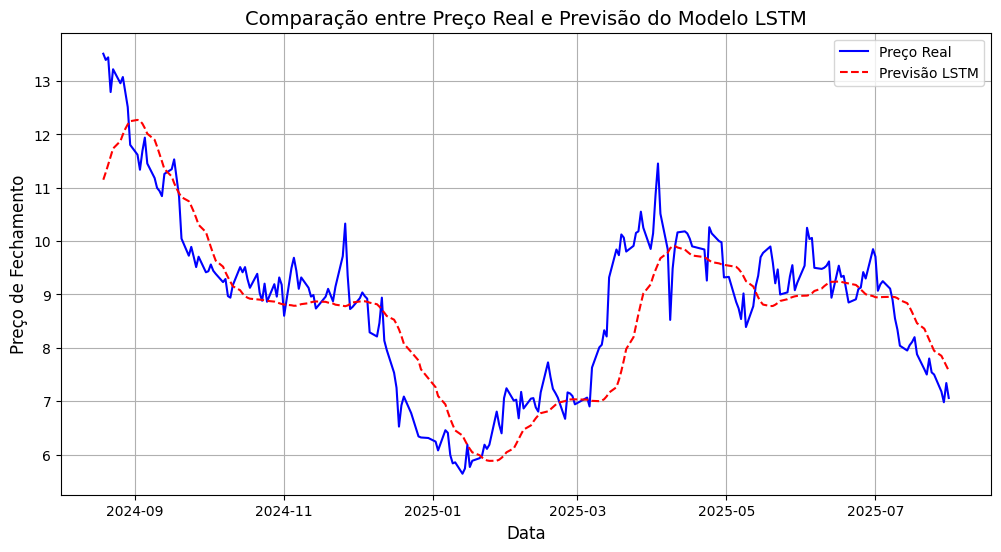

In [58]:
import matplotlib.pyplot as plt

# Criar o gráfico
plt.figure(figsize=(12, 6))
plt.plot(df_teste.index, df_teste["Real"], label="Preço Real", linestyle="-", color="blue")
plt.plot(df_teste.index, df_teste["Previsão"], label="Previsão LSTM", linestyle="--", color="red")

# Adicionar títulos e legendas
plt.title("Comparação entre Preço Real e Previsão do Modelo LSTM", fontsize=14)
plt.xlabel("Data", fontsize=12)
plt.ylabel("Preço de Fechamento", fontsize=12)
plt.legend()
plt.grid(True)

# Mostrar o gráfico
plt.show()


In [ ]:
# Calcular média de acertos e expectativa de lucro
df_teste = df_teste.copy()

df_teste['Variação percentual real'] = df_teste['Real'].pct_change()

#Nova coluna com a variação percentual da ação prevista
df_teste['Variação percentual previsão'] = df_teste['Previsão'].pct_change()

#Remover valores nulos
df_teste = df_teste.dropna()

#Nova coluna com a informação se a ação subiu ou não
df_teste['Ação subiu'] = np.where(df_teste['Variação percentual real'] > 0, 
                                                      True, False)

#Nova coluna com a informação se a previsão subiu ou não
df_teste['Previsão subiu'] = np.where(df_teste['Variação percentual previsão'] > 0, 
                                                      True, False)

#Nova coluna com a informação se o modelo acertou a tendência
df_teste['Modelo acertou tendência'] = np.where(df_teste['Ação subiu'] == df_teste['Previsão subiu']
                                      , True, False)

#Nova coluna com a variação percentual real absoluta
df_teste['Variação percentual real absoluto'] = df_teste['Variação percentual real'].abs()

#calcular media de acertos e expectativa de lucro
acertou_lado = df_teste['Modelo acertou tendência'].sum()/len(df_teste['Modelo acertou tendência'])

#calcular media de erros e expectativa de lucro
errou_lado = 1 - acertou_lado

#calcular media de lucro agrupado por acertos e erros
media_lucro = df_teste.groupby('Modelo acertou tendência')['Variação percentual real absoluto'].mean()

#calcular media de acertos e expectativa de lucro
acertou_lado = df_teste['Modelo acertou tendência'].sum()/len(df_teste['Modelo acertou tendência'])

#calcular media de erros e expectativa de lucro
errou_lado = 1 - acertou_lado

#calcular media de lucro agrupado por acertos e erros
media_lucro = df_teste.groupby('Modelo acertou tendência')['Variação percentual real absoluto'].mean()

#calcular expectativa matematica de lucro
exp_mat_lucro = acertou_lado * media_lucro[1] - media_lucro[0] * errou_lado

#calcular ganho sobre perda
ganho_sobre_perda = media_lucro[1]/media_lucro[0]

#calcular rendimento diario
exp_mat_lucro_percent = exp_mat_lucro * 100

print(f"Media lucro: {media_lucro}")
print(f"Ganho sobre perda: {ganho_sobre_perda}")
print(f"Acertou lado: {acertou_lado}")
print("rendimento diário: " + str(round(exp_mat_lucro_percent, 4)) + "%")


Media lucro: Modelo acertou tendência
False    0.032369
True     0.031381
Name: Variação percentual real absoluto, dtype: float64
Ganho sobre perda: 0.9694766242247163
Acertou lado: 0.538135593220339
rendimento diário: 0.1937%


C:\Users\pedro\AppData\Local\Temp\ipykernel_6976\3695083697.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  exp_mat_lucro = acertou_lado * media_lucro[1] - media_lucro[0] * errou_lado
C:\Users\pedro\AppData\Local\Temp\ipykernel_6976\3695083697.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ganho_sobre_perda = media_lucro[1]/media_lucro[0]


In [60]:
data_hoje = datetime.now()

data_inicio_modelo = ativo.index[0]

if data_hoje.hour > 18:
    final = data_hoje
    inicial = datetime.now() - timedelta(days = 252)
    indicativo_dia = "\nPreço de fechamento amanhã:"
    
else:
    final = data_hoje - timedelta(days = 1)
    inicial = datetime.now() - timedelta(days = 252)
    indicativo_dia = "\nPreço de fechamento hoje:"
    

cotacoes = yf.download(acao, start=inicial, end=final)

ultimos_60_dias = cotacoes['Close'].iloc[-60:].values.reshape(-1, 1)

ultimos_60_dias_df = pd.DataFrame(ultimos_60_dias, columns=scaler.feature_names_in_)
ultimos_60_dias_escalado = scaler.transform(ultimos_60_dias_df)


teste_x = []
teste_x.append(ultimos_60_dias_escalado)
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)


previsao_de_preco = model.predict(teste_x)
previsao_de_preco   = scaler.inverse_transform(previsao_de_preco)

print(indicativo_dia)
print(previsao_de_preco[0][0])



C:\Users\pedro\AppData\Local\Temp\ipykernel_6976\2876931708.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  cotacoes = yf.download(acao, start=inicial, end=final)
[*********************100%***********************]  1 of 1 completed


ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None